In [116]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [117]:
experiment_name = "outer_splits"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [118]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_precision,metrics.test_auprc,metrics.test_loss,metrics.epoch,...,params.pos_weight,params.data/outer_splitter/_target_,params.study_version,params.training/max_lr,params.training/max_epochs,tags.source,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.user
0,a655e62ca4194816bbf695b400d3e430,388500855125955703,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3885008...,2025-05-13 20:29:05.944000+00:00,2025-05-13 20:31:19.065000+00:00,0.795841,0.896983,0.123374,7.0,...,0.8651033236034211,sklearn.model_selection.GroupKFold,5,0.0001,7,train.py,LOCAL,spiffy-smelt-468,train.py,stef
1,9e78eb36ac0e437b9d9f32d4a603023f,388500855125955703,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3885008...,2025-05-13 20:26:28.220000+00:00,2025-05-13 20:28:22.779000+00:00,0.983560,0.953148,0.063856,7.0,...,0.799825622762741,sklearn.model_selection.GroupKFold,5,0.0001,7,train.py,LOCAL,shivering-sheep-233,train.py,stef
2,187c4b97452945f8afba440f408397f1,388500855125955703,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3885008...,2025-05-13 20:23:43.317000+00:00,2025-05-13 20:25:50.627000+00:00,0.883844,0.905207,0.093384,7.0,...,0.8318298117156834,sklearn.model_selection.GroupKFold,5,0.0001,7,train.py,LOCAL,clumsy-steed-477,train.py,stef
3,8d73277818814a8196325f21bf8d69d5,388500855125955703,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3885008...,2025-05-13 20:21:02.370000+00:00,2025-05-13 20:23:00.281000+00:00,0.929418,0.890085,0.159500,7.0,...,0.908303704969952,sklearn.model_selection.GroupKFold,5,0.0001,7,train.py,LOCAL,valuable-fish-315,train.py,stef
4,6c71cc334fc34248a7399e6a1e899356,388500855125955703,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3885008...,2025-05-13 20:18:07.106000+00:00,2025-05-13 20:20:13.396000+00:00,0.911048,0.940781,0.112665,7.0,...,0.9027415475617708,sklearn.model_selection.GroupKFold,5,0.0001,7,train.py,LOCAL,amazing-penguin-887,train.py,stef


In [119]:
df.sort_values(
    by=["metrics.test_auprc"],
    ascending=False,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_precision,metrics.test_auprc,metrics.test_loss,metrics.epoch,metrics.test_auroc,metrics.train_loss,metrics.test_recall,metrics.test_acc,params.training/batch_size,params.model/pred_head_d_hs,...,params.max_lr,params.data/inner_splitter/n_splits,params.data/inner_splitter/_target_,params.training/final_lr,params.training/init_lr,params.pos_weight,params.data/outer_splitter/_target_,params.study_version,params.training/max_lr,params.training/max_epochs
1,0.983560,0.953148,0.063856,7.0,0.991206,0.122746,0.714440,0.968621,102,"[181, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,0.799825622762741,sklearn.model_selection.GroupKFold,5,0.0001,7
4,0.911048,0.940781,0.112665,7.0,0.978904,0.100826,0.818677,0.955359,102,"[181, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,0.9027415475617708,sklearn.model_selection.GroupKFold,5,0.0001,7
7,0.795270,0.940123,0.092422,5.0,0.989799,0.132303,0.878066,0.963233,107,"[120, 186, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,1.0629338837658702,sklearn.model_selection.GroupKFold,0,0.0001,5
5,0.856576,0.934315,0.148343,5.0,0.976325,0.138864,0.858897,0.951320,107,"[120, 186, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,1.1997047254777506,sklearn.model_selection.GroupKFold,0,0.0001,5
2,0.883844,0.905207,0.093384,7.0,0.974339,0.090336,0.780820,0.963340,102,"[181, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,0.8318298117156834,sklearn.model_selection.GroupKFold,5,0.0001,7
0,0.795841,0.896983,0.123374,7.0,0.969279,0.082556,0.794856,0.946410,102,"[181, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,0.8651033236034211,sklearn.model_selection.GroupKFold,5,0.0001,7
3,0.929418,0.890085,0.159500,7.0,0.964832,0.082644,0.580530,0.931323,102,"[181, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,0.908303704969952,sklearn.model_selection.GroupKFold,5,0.0001,7
8,0.836377,0.889377,0.126421,5.0,0.964349,0.141306,0.787945,0.958233,107,"[120, 186, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,1.1054660756491739,sklearn.model_selection.GroupKFold,0,0.0001,5
6,0.792690,0.885957,0.154878,5.0,0.961717,0.127545,0.800085,0.946403,107,"[120, 186, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,1.1496851431694128,sklearn.model_selection.GroupKFold,0,0.0001,5
9,0.877883,0.867961,0.196914,5.0,0.954272,0.140409,0.697413,0.940629,107,"[120, 186, 103]",...,0.0001,3,sklearn.model_selection.GroupKFold,0.001,0.0001,1.2070965936646854,sklearn.model_selection.GroupKFold,0,0.0001,5


In [120]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [122]:
pred_df = pd.read_parquet(
    Path(row.artifact_uri.replace("file:///projects/p30041/spn1560/coarse-grain-rxns", "/home/stef/cgr/artifacts")) / "predictions.parquet"
)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.054884
1,10,1,1.0,0.856928
2,10,2,1.0,0.163022
3,10,3,0.0,0.163022
4,10,4,1.0,0.515513


In [123]:
row['artifact_uri']

'file:///home/stef/cgr/artifacts/mlruns/388500855125955703/9e78eb36ac0e437b9d9f32d4a603023f/artifacts'

In [124]:
preds = []
for _, row in df[df['params.objective'] == 'val_f1'].iterrows():
    preds.append(
        pd.read_parquet(
            Path(row['artifact_uri'].replace("file:///projects/p30041/spn1560/coarse-grain-rxns", "/home/stef/cgr/artifacts")) / "predictions.parquet"
        )
    )

pred_df = pd.concat(preds, ignore_index=True)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,10,0,0.0,0.054884
1,10,1,1.0,0.856928
2,10,2,1.0,0.163022
3,10,3,0.0,0.163022
4,10,4,1.0,0.515513


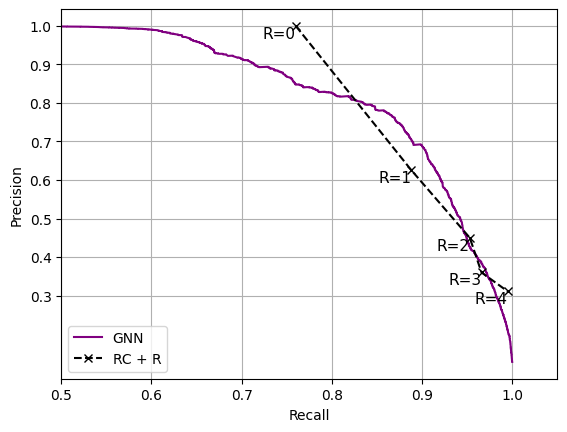

In [125]:
# RC + R stats
recall_from_rcr = [0.76, 0.888, 0.953, 0.966, 0.995]
precision_from_rcr = [1.0, 0.626, 0.450, 0.360, 0.311]
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.05, 0.1))
ax.set_yticks(np.arange(0.3, 1.05, 0.1))
ax.set_xlim(0.5, 1.05)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()